In [1]:
pip install Pillow

In [2]:
!pip install git+https://github.com/aleju/imgaug

  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-4um4f_y_
  Running command git clone -q https://github.com/aleju/imgaug /tmp/pip-req-build-4um4f_y_
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=971107 sha256=ab2001b1b075e704664f7f16c3ae063cb9aabc7532ee6b438217627d5c6af77b
  Stored in directory: /tmp/pip-ephem-wheel-cache-5v9z8h4y/wheels/9c/f6/aa/41dcf2f29cc1de1da4ad840ef5393514bead64ac9e644260ff
Successfully built imgaug


In [3]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import os
import glob
import copy
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
from skimage import io, transform
from torchvision import transforms, utils
from imgaug import augmenters as iaa
import imgaug as ia
import math

In [4]:
# mounting drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# following this tutorial: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
# old image
# path = '/content/drive/MyDrive/COS429_Final_Project/signs_images/train'

# new path to get static images for CNN
# path = '/content/drive/MyDrive/COS429_Final_Project/signs_img_cnn/signs_images/train'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 25

# Batch size for training
batch_size = 8

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = True

In [7]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft) # uncomment later, just taking up space for now

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
model_ft.fc = nn.Sequential(
     nn.Dropout(0.5),
     nn.Linear(model_ft.fc.in_features, num_classes)
)

In [9]:
# dataset and dataloader tutorial
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

# path to the csv file
train_csv_path = '/content/drive/MyDrive/COS429_Final_Project/signs_img_cnn/signs_images/train/sign_labels_train_boston.csv'
val_csv_path = '/content/drive/MyDrive/COS429_Final_Project/signs_img_cnn/signs_images/val/sign_labels_val_boston.csv'

# THE NEW DATASET AND DATALOADER
class SignDataset(Dataset):

  """American Sign Language Dataset"""
  def __init__(self, csv_file, transform):
    """
    Args:
      csv_file (string): Path to the csv file with the annotations.
      transform (callable, optional): Optional transform to be applied on a sample.
    """
    self.csv_file = pd.read_csv(csv_file)
    self.transform = transform
  
  def __len__(self):
    return len(self.csv_file)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    image = cv2.imread(self.csv_file.iloc[idx, 0])
    image = Image.fromarray(image)
    label = self.csv_file.iloc[idx, 1]
    label_int = self.csv_file.iloc[idx, 2]
    sample = {'image': image, 'label': label, 'label_int': label_int}
    
    if self.transform:
      sample['image'] = self.transform(sample['image'])
      
    return sample

class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)
    
# Transformer
train_transform=transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomRotation(20),
        ImgAugTransform(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
val_transform=transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

In [10]:
train_sign_dataset = SignDataset(csv_file=train_csv_path, transform=train_transform)
val_sign_dataset = SignDataset(csv_file=val_csv_path, transform=val_transform)

In [11]:
# Data Loader

# in order to make sure each class has an equal probability of being seen due to our class imbalance
# class_sample_count = [10, 9, 12, 13, 11, 20, 23, 23, 19, 9, 22, 12, 7, 16, 68, 8, 8, 20, 20, 21, 9, 49, 31, 37, 32]
# weights = 1 / torch.Tensor(class_sample_count)
# weights = weights.double()
# print(weights)

# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, num_samples=batch_size, replacement=True)

# WEIGHTED LOADER
# train_sign_dataloader = DataLoader(train_sign_dataset, batch_size=batch_size,
#                         num_workers=0, drop_last=True, sampler=sampler)

# NORMAL LOADER
train_sign_dataloader = DataLoader(train_sign_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0, drop_last=True)

val_sign_dataloader = DataLoader(val_sign_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
# dataloaders dictionary
dataloaders_dict = {'train': train_sign_dataloader, 'val': val_sign_dataloader}

In [12]:
# Helper function to show a batch

# def show_signs_batch(sample_batched):
#     images_batch, label_int = \
#             sample_batched['image'], sample_batched['label_int']
#     batch_size = len(images_batch)
#     im_size = images_batch.size(2)
#     grid_border_size = 2

#     grid = utils.make_grid(images_batch)
#     plt.imshow(grid.numpy().transpose((1, 2, 0)))

#     for i in range(batch_size):
#         plt.title('Batch from dataloader')

# for i_batch, sample_batched in enumerate(train_sign_dataloader):
#     print(sample_batched['image'].size(), sample_batched['label_int'])
#     plt.figure(figsize=(30,30))
#     show_signs_batch(sample_batched)
#     plt.axis('off')
#     plt.ioff()
#     plt.show()

In [13]:
# following this tutorial to get image sequences
# https://discuss.pytorch.org/t/how-upload-sequence-of-image-on-video-classification/24865/9

# COMMENTING OUT BECAUSE DON'T NEED TO READ IN A SEQUENCE OF IMAGES RIGHT NOW
"""
# sampler is used to get valid indices for batches of sequences of imgs
class ImageSampler(torch.utils.data.Sampler):
    def __init__(self, end_idx, seq_length):        
        indices = []
        for i in range(len(end_idx)-1):
            start = end_idx[i]
            end = end_idx[i+1] - seq_length
            indices.append(torch.arange(start, end))
        indices = torch.cat(indices)
        self.indices = indices
        
    def __iter__(self):
        indices = self.indices[torch.randperm(len(self.indices))]
        return iter(indices.tolist())
    
    def __len__(self):
        return len(self.indices)

# homemade dataset to get sequences of images for LSTM 
class ImageSequenceDataset(Dataset):
    def __init__(self, image_paths, seq_length, transform, length):
        self.image_paths = image_paths
        self.seq_length = seq_length
        self.transform = transform
        self.length = length
        
    def __getitem__(self, index):
        start = index
        end = index + self.seq_length
        print('Getting images from {} to {}'.format(start, end))
        indices = list(range(start, end))
        images = []
        for i in indices:
            image_path = self.image_paths[i][0]
            image = cv2.imread(image_path)
            image = Image.fromarray(image)
            if self.transform:
                image = self.transform(image)
            images.append(image)
        image_stack = torch.stack(images)
        label = self.image_paths[i][0].split('/')[7]
        return image_stack, label
        # return images, label
    
    def __len__(self):
        return self.length

root_dir = path
class_paths = [d.path for d in os.scandir(root_dir) if d.is_dir]

class_image_paths = []
end_idx = []
for c, class_path in enumerate(class_paths):
    for d in os.scandir(class_path):
        if d.is_dir:
            paths = sorted(glob.glob(os.path.join(d.path, '*.jpg')))
            # Add class idx to paths
            paths = [(p, c) for p in paths]
            class_image_paths.extend(paths)
            end_idx.extend([len(paths)])

end_idx = [0, *end_idx]
end_idx = torch.cumsum(torch.tensor(end_idx), 0)
seq_length = 10

sampler = ImageSampler(end_idx, seq_length)

# TODO: Fix transformer dimensions
transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
])

dataset = ImageSequenceDataset(
    image_paths=class_image_paths,
    seq_length=seq_length,
    transform=transform,
    length=len(sampler)
)

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=sampler
)

dataloaders_dict = {x: loader for x in ['train']}
"""

"\n# sampler is used to get valid indices for batches of sequences of imgs\nclass ImageSampler(torch.utils.data.Sampler):\n    def __init__(self, end_idx, seq_length):        \n        indices = []\n        for i in range(len(end_idx)-1):\n            start = end_idx[i]\n            end = end_idx[i+1] - seq_length\n            indices.append(torch.arange(start, end))\n        indices = torch.cat(indices)\n        self.indices = indices\n        \n    def __iter__(self):\n        indices = self.indices[torch.randperm(len(self.indices))]\n        return iter(indices.tolist())\n    \n    def __len__(self):\n        return len(self.indices)\n\n# homemade dataset to get sequences of images for LSTM \nclass ImageSequenceDataset(Dataset):\n    def __init__(self, image_paths, seq_length, transform, length):\n        self.image_paths = image_paths\n        self.seq_length = seq_length\n        self.transform = transform\n        self.length = length\n        \n    def __getitem__(self, index):\

In [14]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.95)
# trying a different optimzier, adam
optimizer_ft = optim.Adam(params_to_update, lr=0.00001, weight_decay=0.0001)

In [31]:
from sklearn.metrics import precision_recall_fscore_support as score
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()

    # to check for class accuracies in the final epoch
    class_acc = np.zeros(25)
    class_occ = np.zeros(25)

    val_acc_history = []

    # i made these
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
              
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i_batch, batch in enumerate(dataloaders[phase]):
                inputs = batch['image'].cuda()
                labels = batch['label_int'].cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if(epoch == num_epochs - 1 and phase =='val'):
                      np_labels = labels.cpu().detach().numpy() 
                      # print(np_labels)
                      np_preds = preds.cpu().detach().numpy() 
                      # print(np_preds)
                      for i in range(batch_size):
                        class_occ[np_labels[i]]+=1
                        if(np_labels[i] == np_preds[i]):
                          class_acc[np_preds[i]]+=1
                      # fail
                      # np_labels = labels.cpu().detach().numpy() 
                      # np_preds = preds.cpu().detach().numpy() 
                      # precision, recall, fscore, support = score(np_labels, np_preds)
                      # print('precision: {}'.format(precision))
                      # print('recall: {}'.format(recall))
                      # print('fscore: {}'.format(fscore))
                      # print('support: {}'.format(support))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        

        print()

    class_acc = class_acc/class_occ
    print(class_occ)
    print("class accuracy on last epoch:", class_acc)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, val_loss_history, train_loss_history, class_acc, best_acc

In [32]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, val_acc_history, train_acc_history, val_loss_history, train_loss_history, class_acc, best_acc = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train loss: 0.9876 Acc: 0.7407
val loss: 1.9624 Acc: 0.5662

Epoch 1/49
----------
train loss: 0.9226 Acc: 0.7662
val loss: 2.0038 Acc: 0.5735

Epoch 2/49
----------
train loss: 0.8926 Acc: 0.7662
val loss: 1.9473 Acc: 0.5735

Epoch 3/49
----------
train loss: 0.8806 Acc: 0.7819
val loss: 1.9797 Acc: 0.5735

Epoch 4/49
----------
train loss: 0.8857 Acc: 0.7721
val loss: 1.9670 Acc: 0.5662

Epoch 5/49
----------
train loss: 0.8183 Acc: 0.7898
val loss: 1.9842 Acc: 0.5441

Epoch 6/49
----------
train loss: 0.8030 Acc: 0.7976
val loss: 1.9859 Acc: 0.5662

Epoch 7/49
----------
train loss: 0.8196 Acc: 0.7898
val loss: 1.9920 Acc: 0.5662

Epoch 8/49
----------
train loss: 0.7154 Acc: 0.8173
val loss: 1.9854 Acc: 0.5662

Epoch 9/49
----------
train loss: 0.7425 Acc: 0.8094
val loss: 1.9938 Acc: 0.5662

Epoch 10/49
----------
train loss: 0.7734 Acc: 0.7917
val loss: 1.9884 Acc: 0.5441

Epoch 11/49
----------
train loss: 0.7230 Acc: 0.8251
val loss: 1.9810 Acc: 0.5441

Ep

In [17]:
# plotting the graphs of the training loss and accuracy graphs
# np_train_acc_history = np.zeros(50)
# np_val_acc_history = np.zeros(50)
# np_train_loss_history = np.zeros(50)
# np_val_loss_history = np.zeros(50)
# only need to convert the items 
# for i in range(50):
#   np_train_acc_history[i] = train_acc_history[i].cpu().data.numpy()
#   np_train_loss_history[i] = train_loss_history[i]
#   np_val_acc_history[i] = val_acc_history[i].cpu().data.numpy()
#   np_val_loss_history[i] = val_loss_history[i]
# epochs_array = np.arange(50)
# plt.plot(epochs_array, np_train_loss_history, label="training loss")
# plt.plot(epochs_array, np_train_acc_history, label="training accuracy")
# plt.plot(epochs_array, np_val_loss_history, label="validation loss")
# plt.plot(epochs_array, np_val_acc_history, label="validation accuracy")
# plt.title("Loss/Accuracy over Epochs for Static Image CNN")
# plt.xlabel("Epochs")
# plt.ylabel("Loss/Accuracy")
# plt.legend()
# plt.show()

[1.         0.         0.         0.         0.         0.
 0.66666667 0.5        0.2        1.         1.         0.
 0.5        0.75       1.         0.33333333 0.66666667 1.
 0.6        0.83333333 0.         0.09090909 0.77777778 1.
 1.        ]


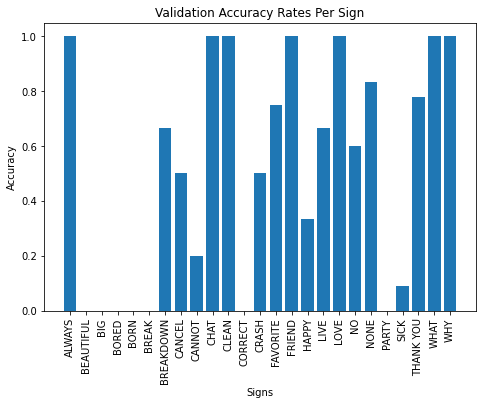

In [33]:
# printing bar graph of class-based classification accuracies
print(class_acc)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
signs = ['ALWAYS', 'BEAUTIFUL', 'BIG', 'BORED', 'BORN', 'BREAK', 'BREAKDOWN', 'CANCEL', 'CANNOT', 
         'CHAT', 'CLEAN', 'CORRECT', 'CRASH', 'FAVORITE', 'FRIEND', 'HAPPY', 'LIVE', 'LOVE', 'NO', 
         'NONE', 'PARTY', 'SICK', 'THANK YOU', 'WHAT', 'WHY']
plt.xticks(rotation='vertical')
ax.bar(signs,class_acc)
plt.title("Validation Accuracy Rates Per Sign")
plt.xlabel("Signs")
plt.ylabel("Accuracy")
plt.show()

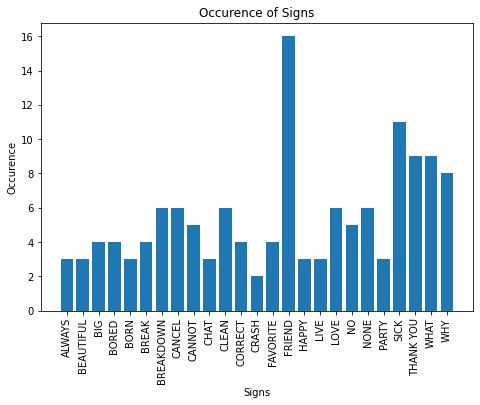

In [38]:
class_occ = [ 3,  3,  4,  4,  3,  4,  6,  6,  5,  3,  6,  4,  2,  4, 16,  3,  3,  6,
  5, 6,  3, 11,  9,  9,  8]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
signs = ['ALWAYS', 'BEAUTIFUL', 'BIG', 'BORED', 'BORN', 'BREAK', 'BREAKDOWN', 'CANCEL', 'CANNOT', 
         'CHAT', 'CLEAN', 'CORRECT', 'CRASH', 'FAVORITE', 'FRIEND', 'HAPPY', 'LIVE', 'LOVE', 'NO', 
         'NONE', 'PARTY', 'SICK', 'THANK YOU', 'WHAT', 'WHY']
plt.xticks(rotation='vertical')
ax.bar(signs,class_occ)
plt.title("Occurence of Signs")
plt.xlabel("Signs")
plt.ylabel("Occurence")
plt.show()

In [19]:
# torch.save(model_ft, '/content/drive/MyDrive/COS429_Final_Project/signs_img_cnn/signs_images/model.npz')

In [20]:
# pretrained_model = torch.load('/content/drive/MyDrive/COS429_Final_Project/signs_img_cnn/signs_images/model.npz')
# pretrained_model.eval()

In [21]:
from csv import writer

def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)

In [22]:
log_file_path = '/content/drive/MyDrive/COS429_Final_Project/signs_img_cnn/signs_images/hyperparams_resent_log.csv'
def hyperparam_script(log_file):
  for i in range(5):
    wd = 0.0001
    lr = 0.1 * math.pow(10, -1 * i)
    print("lr:", lr)
    print("wd:", wd)
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    model_ft = model_ft.to(device)
    params_to_update = model_ft.parameters()
    optimizer_ft = optim.Adam(params_to_update, lr=lr, weight_decay=wd)
    model_ft, hist, best_acc = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    adding = []
    adding.append(lr)
    adding.append(wd)
    adding.append(best_acc)
    append_list_as_row(log_file, adding)

In [23]:
# hyperparam_script(log_file_path)

In [24]:
# %cd /content/drive

In [25]:
# mkdir /content/drive/MyDrive/COS429_Final_Project/signs_img_cnn/signs_images/val/NONE

In [26]:
# %cp /content/drive/MyDrive/COS429_Final_Project/signs_img_cnn/BOSTON_DATASET/NO/sign_203284/sign_203284-5.jpg /content/drive/MyDrive/COS429_Final_Project/signs_img_cnn/signs_images/train/NO/203284-5.jpg

In [27]:
"""
from csv import writer
import shutil
def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)
"""

"\nfrom csv import writer\nimport shutil\ndef append_list_as_row(file_name, list_of_elem):\n    # Open file in append mode\n    with open(file_name, 'a+', newline='') as write_obj:\n        # Create a writer object from csv module\n        csv_writer = writer(write_obj)\n        # Add contents of list as last row in the csv file\n        csv_writer.writerow(list_of_elem)\n"

In [28]:
"""
def copy_file_and_write_to_csv(csv_file, original, target, gloss, number):
  row = []
  row.append(target)
  row.append(gloss)
  row.append(number)
  append_list_as_row(csv_file, row)
  shutil.copyfile(original, target)
"""

'\ndef copy_file_and_write_to_csv(csv_file, original, target, gloss, number):\n  row = []\n  row.append(target)\n  row.append(gloss)\n  row.append(number)\n  append_list_as_row(csv_file, row)\n  shutil.copyfile(original, target)\n'

In [29]:
#csv_file = '/content/drive/MyDrive/COS429_Final_Project/signs_img_cnn/signs_images/val/sign_labels_val.csv'
#original = '/content/drive/MyDrive/COS429_Final_Project/signs_img_cnn/BOSTON_DATASET/NONE/43799/43799-0.jpg'
#target = '/content/drive/MyDrive/COS429_Final_Project/signs_img_cnn/signs_images/val/NONE/43799-0.jpg'
#gloss = 'NONE'
#number = 27

In [30]:
#copy_file_and_write_to_csv(csv_file, original, target, gloss, number)